# NumPy Neural Network

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

The model will have the 2-2-1 architecture, allowing us to solve the XOR problem. Architecture and starting weights are follow the same pattern as in Matt Mazur's [A Step by Step Backpropagation Example](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/), but with following differences: 

* we have only one output
* we are using a different output activation function. 

Why differencet activation function? Matt is doing regression, while we are doing binary classification. Thus, Matt is using a (halved) squared error loss and linear output activation, while we are using binary cross-entropy loss and sigmoid output activation.

In [ ]:
class NumpyNNwithBCE:
    """
    Modularized 2-2-1 Neural Network with Binary Cross-Entropy loss and Sigmoid activations.
    """
    def __init__(self, learning_rate:float=0.1, every_nth_to_print:int=100):
        self.learning_rate = learning_rate
        self.every_nth_to_print = every_nth_to_print # Check print in fit()
        
        # Initialize weights for 2-2-1 architecture
        # W0: Input layer (2 inputs) to hidden layer (2 neurons)
        # Shape: (2, 2)
        self.W0 = np.random.uniform(-0.5, 0.5, size=(2, 2))
        self.b0 = np.zeros((1, 2))
        
        # W1: Hidden layer (2 neurons) to output layer (1 neuron)
        self.W1 = np.random.uniform(-0.5, 0.5, size=(2, 1))
        self.b1 = np.zeros((1, 1))
        
        # Cache for storing intermediate values during forward pass
        self.A0 = np.empty((1, 2))  # Input layer activations
        self.A1 = np.empty((1, 2))  # Hidden layer activations
        self.A2 = np.empty((1, 1))  # Output layer activations

        # Cache for storing gradients during backward pass
        self.dZ1 = np.empty((1, 1))  # Gradient of loss w.r.t. hidden layer
        self.dZ2 = np.empty((1, 1))     # Gradient of loss w.r.t. output layer

        # Counter for manual train_step
        self.manual_epoch: int = 0
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, x):
        # Reshape input
        x = np.atleast_2d(x)
        
        # Layer 0 (input layer)
        self.A0 = x
        
        # Layer 1 (hidden layer)
        net1 = self.A0.dot(self.W0) + self.b0
        self.A1 = self.sigmoid(net1)
        
        # Layer 2 (output layer)
        net2 = self.A1.dot(self.W1) + self.b1
        self.A2 = self.sigmoid(net2)
        
        return self.A2
    
    def backward(self, target):
        # === Output layer ===
        # Gradient of loss wrt Z2 (pre-activation of output neuron)
        # For sigmoid + BCE, this simplifies beautifully to (A2 - y)
        self.dZ2 = self.A2 - target
        
        # === Hidden layer ===
        # Gradient of loss wrt Z1 (pre-activation of hidden layer)
        # Step 1: propagate error back through W1
        dA1 = self.dZ2.dot(self.W1.T)
        # Step 2: apply derivative of activation (sigmoid)
        self.dZ1 = dA1 * self.sigmoid_derivative(self.A1)
    
    def optimize(self):
        """
        Update weights and biases using computed gradients.
        Uses the cached activations and deltas from forward and backward passes.
        """
        # Update W1 and b1 (hidden to output)
        self.W1 -= self.learning_rate * self.A1.T.dot(self.dZ2)
        self.b1 -= self.learning_rate * self.dZ2
        
        # Update W0 and b0 (input to hidden)
        self.W0 -= self.learning_rate * self.A0.T.dot(self.dZ1)
        self.b0 -= self.learning_rate * self.dZ1
    
    def train_step(self, X, y, learning_rate:float|None=None):
        self.learning_rate = learning_rate or self.learning_rate
        self.manual_epoch = self.manual_epoch + 1
        
        # Loop through each sample
        for (x, target) in zip(X, y):
            self.forward(x)
            self.backward(target)
            self.optimize()

        # For manual train_step, we want to be verbose each time
        loss = self.calculate_loss(X, y)
        print("Manual epoch {}: loss={:.7f}".format(self.manual_epoch + 1, loss))
    
    def fit(self, X, y, epochs=1000):
        for epoch in np.arange(0, epochs):
            # Loop through each sample
            for (x, target) in zip(X, y):
                self.forward(x)
                self.backward(target)
                self.optimize()
            
            if epoch == 0 or (epoch + 1) % self.every_nth_to_print == 0:
                loss = self.calculate_loss(X, y)
                print("Epoch {}: loss={:.7f}".format(epoch + 1, loss))
    
    def predict(self, X):

        p = np.atleast_2d(X)
        
        # Layer 0 to Layer 1
        p = self.sigmoid(np.dot(p, self.W0) + self.b0)

        # Layer 1 to Layer 2
        return self.sigmoid(np.dot(p, self.W1) + self.b1)
    
    def calculate_loss(self, X, targets):
        targets = np.atleast_2d(targets)
        
        # Get predictions (clipped to avoid log(0))
        predictions = self.predict(X)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        
        # Binary cross-entropy loss
        # L = -sum(y * log(y_pred) + (1-y) * log(1-y_pred))
        loss = -np.sum(
            targets * np.log(predictions) 
            + 
            (1 - targets) * np.log(1 - predictions)
        )
        return loss


## Simple data

Let's use a dataset consisting of only four samples. Note that this will not always find the solution; if not, run again. If we would want to improve this, we could try multiple different ideas:

* Initialize weights using some other method (e.g. Xavier initialization)
* Use more neurons in the hidden layer
* Use learning rate decay or momentum

In [77]:
model = NumpyNNwithBCE(learning_rate=0.03, every_nth_to_print=2000)

X = np.array([[0, 0], 
              [0, 1], 
              [1, 0], 
              [1, 1]])
y = np.array([[0], 
              [1], 
              [1], 
              [0]])
model.fit(X, y, epochs=20_000)

Epoch 1: loss=2.7771869
Epoch 2000: loss=2.7729745
Epoch 4000: loss=2.7727010
Epoch 6000: loss=2.7718395
Epoch 8000: loss=2.7202300
Epoch 10000: loss=1.6472858
Epoch 12000: loss=0.2356260
Epoch 14000: loss=0.1016045
Epoch 16000: loss=0.0633922
Epoch 18000: loss=0.0457655
Epoch 20000: loss=0.0357028


In [75]:
y_pred = model.predict(X)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# Slightly more complex data

<Axes: >

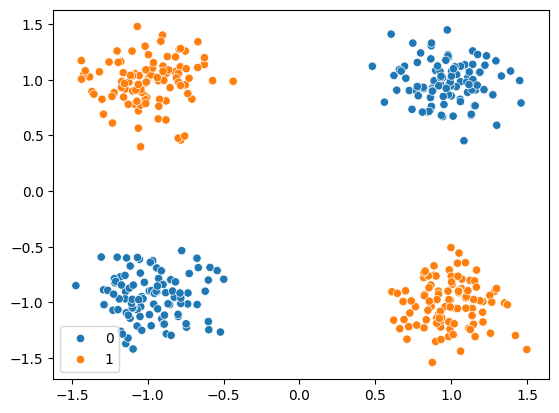

In [65]:
# Generate XOR data using numpy
# We will generate four "blobs" of point around the mathematically correct XOR points (0,0), (0,1), (1,0), (1,1)
np.random.seed(0)
n_points = 100
noise = 0.1

X = np.vstack((
    np.random.normal(loc=[0.0, 0.0], scale=noise, size=(n_points, 2)),
    np.random.normal(loc=[1.0, 1.0], scale=noise, size=(n_points, 2)),
    np.random.normal(loc=[0.0, 1.0], scale=noise, size=(n_points, 2)),
    np.random.normal(loc=[1.0, 0.0], scale=noise, size=(n_points, 2))
))
y = np.array([0]*n_points + [0]*n_points + [1]*n_points + [1]*n_points).reshape(-1, 1)

# Apply Z-score normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Visualize the data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y.flatten())

## Train and plot results

Epoch 1: loss=294.0478006
Epoch 500: loss=2.2772338
Epoch 1000: loss=1.0499628
Epoch 1500: loss=0.6795909
Epoch 2000: loss=0.5016098


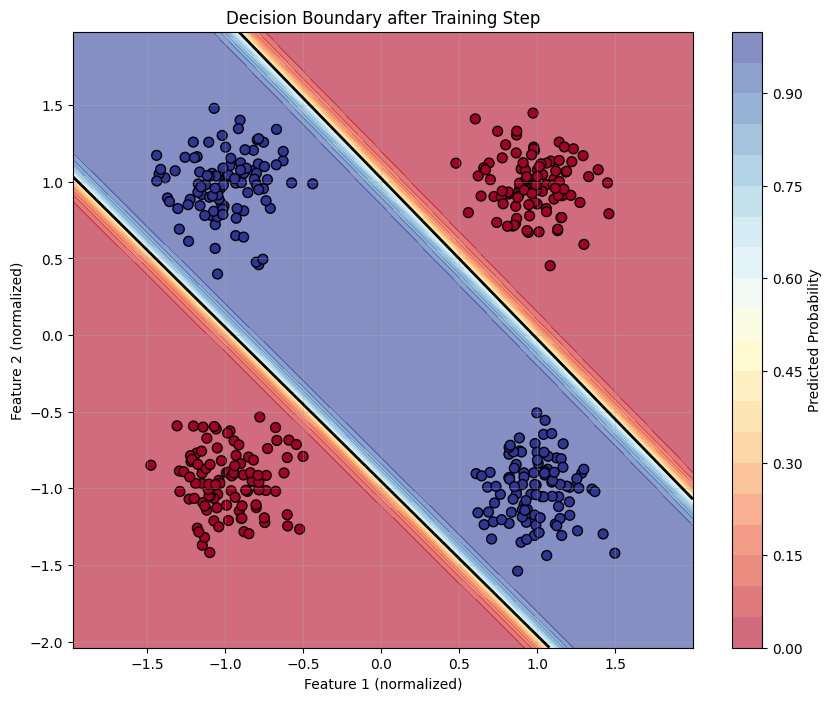

In [69]:
model = NumpyNNwithBCE(learning_rate=0.01, every_nth_to_print=500)

# Train complete model instead
model.fit(X, y, epochs=2_000)

# Create a mesh grid for decision boundary visualization
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on the mesh grid
Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
plt.colorbar(label='Predicted Probability')
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Plot the data points
scatter = plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), 
                     cmap='RdYlBu', edgecolors='black', s=50)
plt.xlabel('Feature 1 (normalized)')
plt.ylabel('Feature 2 (normalized)')
plt.title('Decision Boundary after Training Step')
plt.grid(True, alpha=0.3)
plt.show()